# <img src="./resources/GA.png" width="25" height="25" />   <span style="color:Purple">Project 5 :  Food Insecurity Regression Study</span> 
---
## <span style="color:Green">03 - Preprocessing / Modeling</span>      

#### Alec Edgecliffe-Johnson, Ryan McDonald, Andrew Roberts, Ira Seidman- General Assembly 



---

### Notebook Contents:

- [Reading the Data](#intro)
- [Modeling](#modeling)
    - [Production Model, LinReg](#prod)
         - [Extended Analysis](#analysis)
    - [Model #2, KNN](#second)
    - [Model #3, Decision Tree](#third)
    - [Model #4, PolyFeat, LinReg](#fourth)
    - [Model #5, ADA Boost](#fifth)
    - [Model #6, SVM](#sixth)
    - [Model #7, TensorFlow NN](#seventh)
    - [Model #8, RandomForest](#eigth)
    - [Model #9, PCA, LinReg](#ninth)


**Imports**

In [1]:
import pandas as pd
import numpy as np

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns

# SciKit Learn Processing/ Modeling Imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Tensor Flow, Keras NN
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.utils import plot_model


<a id='intro'></a>

## 1. Read the Data

In [2]:
df = pd.read_csv('data/df_final.csv')

<a id='modeling'></a>
## Modeling Pre-work

**Setting X, y and Train-Test-Split**

In [3]:
features = df.drop(columns = ['ch_fi_rate_18', 'fi_rate_18', 'cpm_18', 
                       'state_abr', 'state_name', 'fips', 'county'])

X = features
y = df['fi_rate_18']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

In [4]:
# Scaling Data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

<a id='prod'></a>
### Model 1: Production Model

**Linear Regression**

In [5]:
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

In [6]:
# Setting up the Pipeline/ GridSearch

pipe_ln = Pipeline([
    ('ln', LinearRegression()),
])

pipe_ln_params = { 'ln__fit_intercept': [False, True],
                  'ln__copy_X': [False, True],
                  'ln__normalize': [False, True]
}

pipe_ln.fit(Z_train, y_train)
gs_ln = GridSearchCV(pipe_ln, 
                        param_grid = pipe_ln_params, 
                        cv=5)
 
gs_ln.fit(Z_train, y_train);

In [7]:
print(gs_ln.best_score_)
gs_ln.best_params_

0.9331071494649233


{'ln__copy_X': False, 'ln__fit_intercept': True, 'ln__normalize': False}

In [8]:
ln_preds_train = gs_ln.predict(Z_train)
ln_preds_test = gs_ln.predict(Z_test)

print(f'ln Training RMSE: {mean_squared_error(y_train, ln_preds_train, squared = False)}')
print(f'ln Testing RMSE: {mean_squared_error(y_test, ln_preds_test, squared = False)}')

ln Training RMSE: 0.9242882324129449
ln Testing RMSE: 0.9967000195040715


Our model predicts Food Insecurity Rates, on average, within 0.99 points of the actual data.  One could assume this model could be successfull in predicting Food Insecurity well when apporached by unseen data.

In [9]:
print(f'Training R2: {pipe_ln.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_ln.score(Z_test, y_test)}')

Training R2: 0.9386462698301442
Testing R2: 0.9330074240127388


Linear regression can account for nearly 94% of the variability in our data. 

In [11]:
feature_names = features
coefs_ln = pipe_ln.named_steps['ln'].coef_.flatten()
model_zip = zip(feature_names, coefs_ln)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
44,percent_disabled,0.767051
16,percent_children_in_poverty,0.552381
5,percent_fair_or_poor_health,0.470569
28,percent_severe_housing_cost_burden,0.334582
20,percent_severe_housing_problems,0.288251
39,percent_below_poverty,0.192885
18,percent_single_parent_households_CHR,0.174937
17,num_households_CHR,0.161619
40,percent_unemployed_CDC,0.151693
43,percent_age_17_and_younger,0.143348


In [14]:
# Saving a csv copy for tableau
lr_coef_10= model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)
lr_coef_10.to_csv('./resources/lr_coef_tableau.csv', index = False)

<a id='analysis'></a>
### Production Model Analysis 

Testing results are strong with Linear Regression.  Considering all of the additional modeling techniques explored, it was surprising that a more straight-forward, Linear Regression would offer such good results as well as be easily interpretable.  

Utilizing all of our numerical features shows a good fit in train and testing results,  **0.93 and 0.93 respectively** (less than 1% difference between the two).  Our RMSE scores were also aligned.  Looking into our feature coefficients (top ten shown above) although not all features show a positive coefficient, all else held equal, ‘percent_disabled’ had the highest coefficients with a 0.767% increase in food insecurity per percent increase in 'percent_disabled'. Several other features, ‘percent_children_in_poverty’, ‘percent_fair_or_poor_health’ and ‘percent_severe_housing_cost_burden’, among others, rounded the top of the list.
The predictive power of these features aren’t a surprise.  One could assume with limited resources or physical health, food insecurity could follow.  What’s most meaningful is the top ten features all exhibit an assumed ‘negative’ condition.  And the combination of these features can have a detrimental affect to ones wellbeing.  


<a id='second'></a>
### Model 2: KNN

In [11]:
KNeighborsRegressor().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [12]:
# Setting up the Pipeline/ GridSearch

pipe_knn = Pipeline([
    ('knn', KNeighborsRegressor())
])

pipe_knn_params = { 'knn__n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            }

pipe_knn.fit(Z_train, y_train)
gs_knn = GridSearchCV(pipe_knn, 
                        param_grid = pipe_knn_params, 
                        cv=5)

gs_knn.fit(Z_train, y_train);

In [13]:
print(gs_knn.best_score_)
gs_knn.best_params_

0.851301455655712


{'knn__n_neighbors': 5}

In [14]:
knn_preds_train = gs_knn.predict(Z_train)
knn_preds_test = gs_knn.predict(Z_test)

print(f'knn Training RMSE: {mean_squared_error(y_train, knn_preds_train, squared = False)}')
print(f'knn Testing RMSE: {mean_squared_error(y_test, knn_preds_test, squared = False)}')

knn Training RMSE: 1.1430855549727068
knn Testing RMSE: 1.4479205383412166


In [15]:
print(f'Training R2: {pipe_knn.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_knn.score(Z_test, y_test)}')

Training R2: 0.9061609510423924
Testing R2: 0.8586202527205257


**Quick Analysis**

These results show a bit of overfitting.  And the best results were shown from n_neighbors = 5.  However, 'feature similarity' is still not performing better than the production model.

<a id='third'></a>
### Model 3: Decision Tree

In [16]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [17]:
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [18]:
# Setting up the Pipeline/ GridSearch
pipe_dt = Pipeline([
    ('dt', DecisionTreeRegressor())
])

pipe_dt_params = {'dt__max_depth': [5, 10, None], 
                  'dt__max_features': ['auto', 'log2'], 
                'dt__max_depth': [2,4,6,8,10,12]
                 }

pipe_dt.fit(Z_train, y_train)
gs_dt = GridSearchCV(pipe_dt, 
                        param_grid = pipe_dt_params, 
                        cv=5)

gs_dt.fit(Z_train, y_train);

In [19]:
print(gs_dt.best_score_)
gs_dt.best_params_

0.7862759139325266


{'dt__max_depth': 6, 'dt__max_features': 'auto'}

In [20]:
dt_preds_train = gs_dt.predict(Z_train)
dt_preds_test = gs_dt.predict(Z_test)

print(f'dt Training RMSE: {mean_squared_error(y_train, knn_preds_train, squared = False)}')
print(f'dt Testing RMSE: {mean_squared_error(y_test, knn_preds_test, squared = False)}')

dt Training RMSE: 1.1430855549727068
dt Testing RMSE: 1.4479205383412166


In [21]:
print(f'Training R2: {pipe_dt.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_dt.score(Z_test, y_test)}')

Training R2: 1.0
Testing R2: 0.7839621671931096


**Quick Analysis**

DT Regressor shows significant overfitting.  This can be resolved by increasing bias/ reducing the number of features utilized, including a Random Forest analysis, etc. But, with the relative scores and development of the production model, this model was abandoned.

<a id='fourth'></a>
### Model 4: PolynomialFeatures with StandardScalar and Linear Regression

In [22]:
features = ['percent_children_in_poverty', 'percent_below_poverty', 'percent_fair_or_poor_health',
            'pct_overall_pov_19','percentile_rank_social_vulnerability']

X = df[features]
y = df['fi_rate_18']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)
pf = PolynomialFeatures(degree=2)
X_train_pf = pf.fit_transform(X_train)
X_test_pf = pf.transform(X_test)




In [23]:
LinearRegression().get_params().keys(), PolynomialFeatures().get_params().keys()

(dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize']),
 dict_keys(['degree', 'include_bias', 'interaction_only', 'order']))

In [24]:
# Setting up the Pipeline/ GridSearch
pipe_ln = Pipeline([
    ('ss', StandardScaler()),
    ('ln', LinearRegression()),
#     ('model', LassoCV())
])
pipe_ln_params = {'ln__normalize':[True, False],
                  'ln__fit_intercept':[True, False]
#                   'model__alpha':[0.001, 0.01, 0.1],
#                   'model__max_iter':[1000, 2000],
#                   'model__normalize':[True, False]
                  }

pipe_ln.fit(X_train_pf, y_train)
gs_ln = GridSearchCV(pipe_ln, 
                        param_grid = pipe_ln_params, 
                        cv=5)

gs_ln.fit(X_train_pf, y_train);

ln_preds_train = gs_ln.predict(X_train_pf)
ln_preds_test = gs_ln.predict(X_test_pf)
print(f'ln Training RMSE: {mean_squared_error(y_train, ln_preds_train, squared = False)}')
print(f'ln Testing RMSE: {mean_squared_error(y_test, ln_preds_test, squared = False)}')
print(f'Training R2: {pipe_ln.score(X_train_pf, y_train)}')
print(f'Testing R2: {pipe_ln.score(X_test_pf, y_test)}')

feature_names = features
coefs_ln = pipe_ln.named_steps['ln'].coef_.flatten()
model_zip = zip(feature_names, coefs_ln)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False)

ln Training RMSE: 1.652341472472501
ln Testing RMSE: 1.692077560336421
Training R2: 0.8039234164197737
Testing R2: 0.8069195616440654


,features,coefficients
3,pct_overall_pov_19,2.285601
1,percent_below_poverty,1.365929
4,percentile_rank_social_vulnerability,0.095530
2,percent_fair_or_poor_health,0.051696
0,percent_children_in_poverty,0.000000


In [25]:
print(gs_ln.best_score_)
gs_ln.best_params_

0.7976139661653221


{'ln__fit_intercept': True, 'ln__normalize': True}

**Will Lasso Improve our Score?**

In [26]:
lasso=LassoCV(max_iter=15000 )
lasso.fit(X_train_pf, y_train)

LassoCV(max_iter=15000)

In [27]:
print(f"Lasso CV Training R=Squared: {lasso.score(X_train_pf, y_train)}")
print(f"Lasso CV Testing R=Squared: {lasso.score(X_test_pf, y_test)}")

Lasso CV Training R=Squared: 0.7573510458114212
Lasso CV Testing R=Squared: 0.7827335296909608


**Quick Analysis**

With several different numbers of features tested, adding Lasso, and running a gridseearched pipeline not improving the results, PolynomialFeatures was not selected as the produciton model. It just couldn't out-perform.  We did believe that addigin additional engineer features/ feature pairs would increase the performance. But, it did not. 

<a id='fifth'></a>
### Model 5: ADA Boost

In [28]:
features = df.drop(columns = ['ch_fi_rate_18', 'fi_rate_18', 'cpm_18', 
                       'state_abr', 'state_name', 'fips', 'county'])



#### Setting Feature and Target Variables
**Scaling and Train-Test-Split**

In [29]:
X = features
y = df['fi_rate_18']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

# random seed for the rest of the notebook
np.random.seed(42)

AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [30]:
pipe_ada = Pipeline([
    ('ada', AdaBoostRegressor())
])


# https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781787286382/9/ch09lvl1sec95/tuning-an-adaboost-regressor
pipe_ada_params = {  
 'ada__n_estimators': [100, 150, 200],
 'ada__learning_rate' : [1, 5, 10],
 'ada__loss' : ['linear', 'square', 'exponential']
}


pipe_ada.fit(Z_train, y_train)
gs_ada = GridSearchCV(pipe_ada, 
                        param_grid = pipe_ada_params, 
                        cv=5)

gs_ada.fit(Z_train, y_train);

ada_preds_train = gs_ada.predict(Z_train)
ada_preds_test = gs_ada.predict(Z_test)
print(f'Best Parameters: {gs_ada.best_params_}')

print(f'AdaBoost Training RMSE: {mean_squared_error(y_train, ada_preds_train, squared = False)}')
print(f'AdaBoost Testing RMSE: {mean_squared_error(y_test, ada_preds_test, squared = False)}')
print(f'Training R2: {pipe_ada.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_ada.score(Z_test, y_test)}')

Best Parameters: {'ada__learning_rate': 1, 'ada__loss': 'square', 'ada__n_estimators': 200}
AdaBoost Training RMSE: 1.2808240287820896
AdaBoost Testing RMSE: 1.4559115334852997
Training R2: 0.8748507243766415
Testing R2: 0.846666164902464


In [31]:
feature_names = features
coefs_ada = pipe_ada.named_steps['ada'].feature_importances_
model_zip = zip(feature_names, coefs_ada)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
16,percent_children_in_poverty,0.193044
39,percent_below_poverty,0.151260
48,pct_overall_pov_19,0.133538
22,life_expectancy,0.075478
25,median_household_income,0.062817
47,percentile_rank_social_vulnerability,0.058584
6,average_number_of_mentally_unhealthy_days,0.058199
44,percent_disabled,0.048597
5,percent_fair_or_poor_health,0.039349
40,percent_unemployed_CDC,0.036158


**Quick Analysis**

ADA Boost performed well with our data. It only showed slight signs of overfitting, which was expected.  Being a sequential learners, ADA Boost does a great job combine weaker features to enhance scores and generate different models sequentially, learning the mistakes of some runs to enhance results of the final output. The coefficients are not as easily interpreted, and since the score could not improve above our production model, and it's slow to run, it was dropped. 

<a id='sixth'></a>
### Model 6: Support Vector Machines

In [32]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [33]:
# Setting up Pipeling and GridSearch
pipe_svr = Pipeline([
    ('svr', SVR(kernel='linear'))
])


pipe_svr_params = {  
 'svr__C': [.01, .1, 1, 10, 100]
}


pipe_svr.fit(Z_train, y_train)
gs_svr = GridSearchCV(pipe_svr, 
                        param_grid = pipe_svr_params, 
                        cv=5,
                        n_jobs=4
)

gs_svr.fit(Z_train, y_train);

svr_preds_train = gs_svr.predict(Z_train)
svr_preds_test = gs_svr.predict(Z_test)

print(f'SVR Training RMSE: {mean_squared_error(y_train, svr_preds_train, squared = False)}')
print(f'SVR Testing RMSE: {mean_squared_error(y_test, svr_preds_test, squared = False)}')
print(f'Training R2: {pipe_svr.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_svr.score(Z_test, y_test)}')

SVR Training RMSE: 0.9366578780068757
SVR Testing RMSE: 1.0006495337045944
Training R2: 0.9369931011152008
Testing R2: 0.9324754437734858


In [34]:
# attribute error associated with coefficents. Can't get coefficents, but since we are seeking accuracy over interpretability then that is OK.

feature_names = features
coefs_svr = pipe_svr.named_steps['svr'].coef_
model_zip = zip(feature_names, coefs_svr)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False)

,features,coefficients
0,lat,"[-0.09500268194691941, 0.0772224931192671, -0.014253348458105108, 0.03745356823913326, 0.052440934151810836, 0.5180078169045643, 0.1416306703463981, 0.14468979679552696, -0.012546599994928798, 0.06713975914042791, -3.7580612295956115, 0.048092961344494256, 0.04177971424301852, 0.15416030270655412, 0.039294403618672646, -0.05091340760771246, 0.5870801435946982, 0.03757776877539598, 0.2117905914182785, -0.14392124768969694, 0.3319907475937356, -0.5844828096041823, -0.10439769066995197, 0.050044025360961086, -2.453014102692862, -0.05827058903630267, -0.14594184279148337, 0.08039420776725947, 0.25772401259429145, -0.8685884039454379, -0.3372026223509952, -0.031491387111373115, 0.0389980182714007, 0.0256545867496607, 0.21795956150827145, -0.037170137324244124, -0.0437330207670108, 0.0860010465387262, 0.029882224778358335, 0.13898011902101004, 0.13922389576088, -0.20061017897080546, -0.08966947551140692, 0.14212780832455962, 0.7487627440467719, 0.31101864715489924, 0.1368048635809611, -0.0559836936898499, -0.20513823247270935, 0.16847325423994874, -0.2119712351902443, 0.05897082147129851, -0.048334020328343996]"


**Quick Analysis**

Results were excellent for SVM regression.  Both R2 and RMSE were just a hair under our production model.  The speed of this model is also very attractive.  However, it's 'black box'  operations are not easily explained to customers/etc. so we dropped it in favor of our Production Model. 

<a id='seventh'></a>
### Model 7: TensorFlow NN

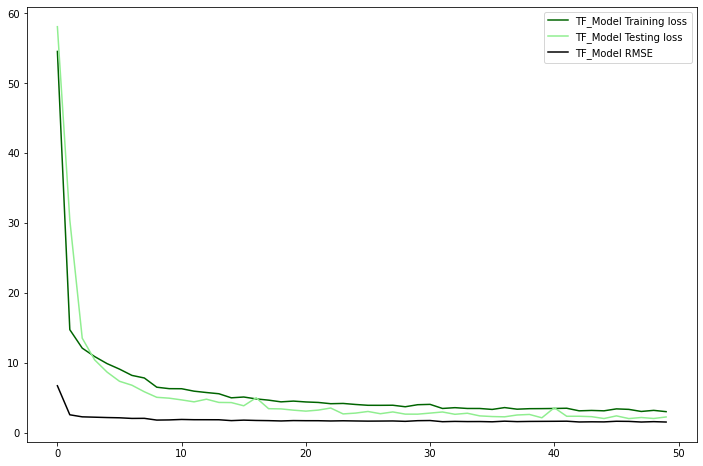

In [35]:
features = df.drop(columns = ['ch_fi_rate_18', 'fi_rate_18', 'cpm_18', 
                       'state_abr', 'state_name', 'fips', 'county'])

X = features
y = df['fi_rate_18']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

# Scaling Data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

rmse = RootMeanSquaredError()

model = Sequential()

model.add(Dense(64, input_shape = (Z_train.shape[1], ),
                  activation = 'relu',
                  ))

model.add(BatchNormalization())   # BatchNormalization layer added from Part 7

model.add(Dense(128, activation = 'relu', 
                  kernel_regularizer = l2(0.01)
                  )) # Second hidden layer
model.add(Dropout(0.05))  # Dropout layer 5 % to 2nd layer

model.add(Dense(64, activation = 'relu', 
                  kernel_regularizer = l2(0.1)
                  )) # Third hidden layer
model.add(Dropout(0.20))  # Dropout layer 20 % to 3rd layer

# Add output layer

model.add(Dense(1, activation = None)) 

# Compile it
model.compile(loss = 'mse' ,optimizer = 'adam', metrics= [rmse,'mse'])                                     
# early_stop object


early_stop = EarlyStopping(patience=5)

# Fit it
results_es = model.fit(Z_train, y_train,
            validation_data= (Z_test, y_test),
            epochs = 50, 
            verbose = 0,
            callbacks = [early_stop])

# Visualize loss
train_loss = results_es.history['loss']
test_loss = results_es.history['val_loss']
train_rmse = results_es.history['root_mean_squared_error']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='TF_Model Training loss', color='darkgreen')
plt.plot(test_loss, label='TF_Model Testing loss', color='lightgreen')
plt.plot(train_rmse, label='TF_Model RMSE', color='Black')

plt.legend();

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3456      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

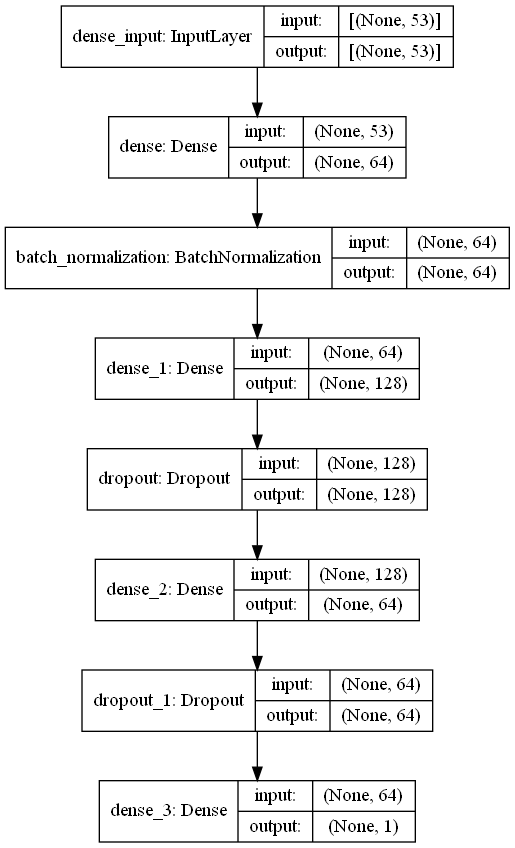

In [37]:
plot_model(model, show_layer_names=True, show_shapes=True)


In [38]:
results_es.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mse', 'val_loss', 'val_root_mean_squared_error', 'val_mse'])

In [39]:
# TF Training RMSE
results_es.history['root_mean_squared_error'][-1]

1.539659023284912

In [40]:
# TF Testing RMSE
results_es.history['val_root_mean_squared_error'][-1]

1.2717992067337036

**Quick Analysis**

Is utilizing a Neuro Network for a regression problem overkill?!  Of course not!  Unfortunately though, the model did not perform as well as out production model. Sometimes, simplier IS better.

<a id='eigth'></a>
### Model 8: Random Forest Regressor

In [41]:
features = df.drop(columns = ['ch_fi_rate_18', 'fi_rate_18', 'cpm_18', 
                       'state_abr', 'state_name', 'fips', 'county'])

X = features
y = df['fi_rate_18']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

# Scaling Data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [42]:
RandomForestRegressor().get_params().keys()
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor())
])
pipe_rf_params = { 'rf__max_depth': [5,10,None],
                 }
pipe_rf.fit(Z_train, y_train)
gs_rf = GridSearchCV(pipe_rf, 
                        param_grid = pipe_rf_params, 
                        cv=5)
gs_rf.fit(Z_train, y_train);
print(gs_rf.best_score_)
gs_rf.best_params_
rf_preds_train = gs_rf.predict(Z_train)
rf_preds_test = gs_rf.predict(Z_test)
print(f'rf Training RMSE: {mean_squared_error(y_train, rf_preds_train, squared = False)}')
print(f'rf Testing RMSE: {mean_squared_error(y_test, rf_preds_test, squared = False)}')
print(f'Training R2: {pipe_rf.score(Z_train, y_train)}')
print(f'Testing R2: {pipe_rf.score(Z_test, y_test)}')

0.887299097570186
rf Training RMSE: 0.4603600455620513
rf Testing RMSE: 1.22867205826111
Training R2: 0.9846502714097256
Testing R2: 0.8982919463645113


**Quick Analysis**

As expected, severe overfitting.  And with the score considerably less than our production model, we decided not to persue the model any further.

<a id='ninth'></a>
### Model 9: PCA Pipeline w/ Lin Reg

In [44]:
# Setting up the Pipeline/ GridSearch
pipe_ln = Pipeline([
    ('pca', PCA()),
    ('ln', LinearRegression()),
])
pipe_ln_params = {'ln__normalize':[True, False],
                  'ln__fit_intercept':[True, False],
                  'pca__n_components':[5, 7, 10, 12, 15, 20, 30, 50],
                  'pca__random_state':[42, 2021],
                  'pca__tol':[0, 0.1, 1],
                  'pca__whiten':[True, False],
                  'pca__svd_solver':['auto','full', 'arpack','randomized'],
                  'pca__iterated_power': [0, 1, 2, 3]
                  }

pipe_ln.fit(Z_train, y_train)
gs_ln = GridSearchCV(pipe_ln, 
                        param_grid = pipe_ln_params, 
                        cv=5)

gs_ln.fit(Z_train, y_train);

ln_preds_train = gs_ln.predict(Z_train)
ln_preds_test = gs_ln.predict(Z_test)
print(f'ln/PCA Training RMSE: {mean_squared_error(y_train, ln_preds_train, squared = False)}')
print(f'ln/PCA Testing RMSE: {mean_squared_error(y_test, ln_preds_test, squared = False)}')
print(f'Training ln/PCA R2: {pipe_ln.score(Z_train, y_train)}')
print(f'Testing ln/PCA R2: {pipe_ln.score(Z_test, y_test)}')
gs_ln.best_params_

ln/PCA Training RMSE: 0.9273531513274436
ln/PCA Testing RMSE: 0.995970366150852
Training ln/PCA R2: 0.9386462698301442
Testing ln/PCA R2: 0.9330074240127391


{'ln__fit_intercept': True,
 'ln__normalize': True,
 'pca__iterated_power': 1,
 'pca__n_components': 50,
 'pca__random_state': 42,
 'pca__svd_solver': 'randomized',
 'pca__tol': 0,
 'pca__whiten': True}

In [45]:
feature_names = features
coefs_ln = pipe_ln.named_steps['ln'].coef_.flatten()
model_zip = zip(feature_names, coefs_ln)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
47,percentile_rank_social_vulnerability,3.492955
51,percent_of_adults_completing_some_college_or_associate_degree,2.024759
43,percent_age_17_and_younger,2.004308
45,percent_minorities,0.937395
52,percent_of_adults_with_bachelor_degree_or_higher,0.917534
0,lat,0.845822
33,percent_hispanic,0.763944
42,percent_age_65_and_older,0.757841
17,num_households_CHR,0.551398
9,percent_adults_with_obesity,0.453918


**Quick Analysis**

Pulling in PCA was a must for our team.  Having just begun to learn the advantages of the algo we wanted to see it in action. And... it actually performed a little better than our production model.. Just barely.  And, since the model is costly (computing) to run, and lacks appropriate interpretability.  We decided to drop it in favor of regular Linear Regression.  